In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [53]:
# same folder --> folder data

path_original = "data/Original/full_used_car_prices_original.csv"
path_generated = "data/Generated/full_used_car_prices_generated.csv"

data_original = pd.read_csv(path_original)
data_generated = pd.read_csv(path_generated)

In [54]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


In [55]:
data_generated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314223 entries, 0 to 314222
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            314223 non-null  int64  
 1   brand         314223 non-null  object 
 2   model         314223 non-null  object 
 3   model_year    314223 non-null  int64  
 4   milage        314223 non-null  int64  
 5   fuel_type     305757 non-null  object 
 6   engine        314223 non-null  object 
 7   transmission  314223 non-null  object 
 8   ext_col       314223 non-null  object 
 9   int_col       314223 non-null  object 
 10  accident      310139 non-null  object 
 11  clean_title   278565 non-null  object 
 12  price         188533 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 31.2+ MB


Transformation of the price column from $ to float in the original dataset.

In [56]:
data_original.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [57]:
data_original['price'] = data_original['price'].str.replace('$', '')
data_original['price'] = data_original['price'].str.replace(',', '')
data_original['price'] = data_original['price'].astype(int)
data_original['price'].head()

0    10300
1    38005
2    54598
3    15500
4    34999
Name: price, dtype: int32

# Creating the test and train datasets

### Distribution of the Target Variable

Since we would like to apply stratified sampling, we need to know the distribution of the target variable (for binning the continuous target variable). Since the target variable is heavily right-skewed (as seen in the histogram below), we will use log transformation to make it more normally distributed.

2954083
14.898698839173656


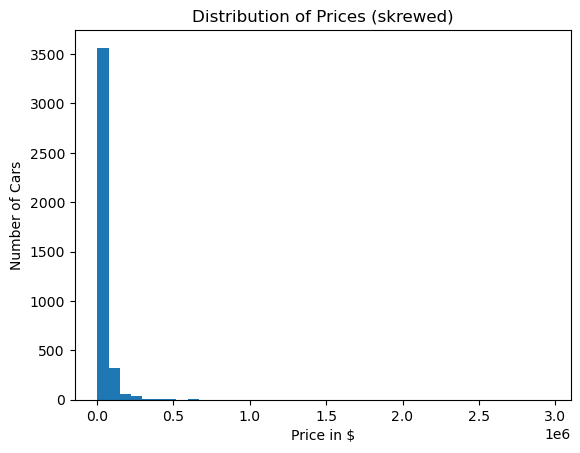

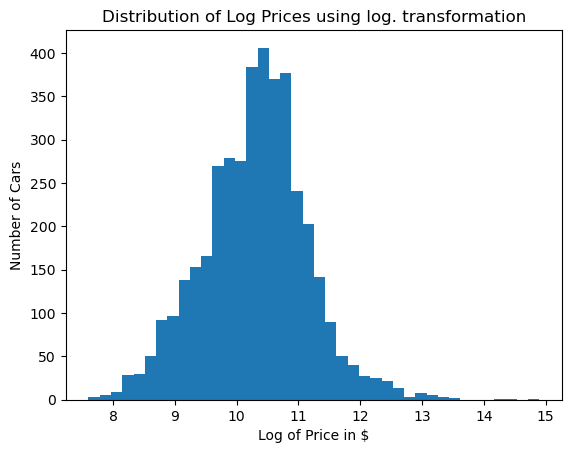

In [75]:
# target column
y_original = data_original["price"]

# Use the log of the target column
y_original_ln = np.log(y_original)
print(max(y_original))
print(max(y_original_ln))

# Histogram of the target column
plt.title('Distribution of Prices (skrewed)')
plt.hist(y_original, bins=40)
plt.xlabel('Price in $')
plt.ylabel('Number of Cars')
plt.show()

# Histogram of the ln target column
plt.title('Distribution of Log Prices using log. transformation')
plt.hist(y_original_ln, bins=40)
plt.xlabel('Log of Price in $')
plt.ylabel('Number of Cars')
plt.show()

We can see that there are some outliers in the target variable. We will take a look at the 20 most expensive cars in the dataset.

In [59]:
# Print the 10 largest values of the target column
print(y_original.nlargest(20))

693     2954083
229     1950995
3046    1599000
1356     749950
624      695000
979      649999
1615     599995
1508     599000
3655     491836
1061     489995
1148     489000
304      488880
2133     479995
1597     469900
487      449995
2111     449991
203      429998
3611     425000
180      417500
3816     399950
Name: price, dtype: int32


We agreed to remove the three samples with over 1 mio. USD in the target variable, since they are outliers and would distort the distribution greatly.

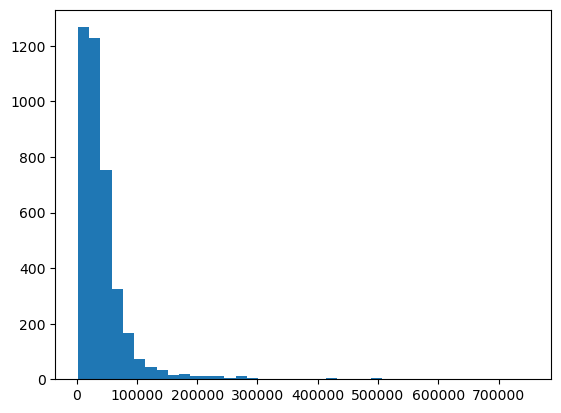

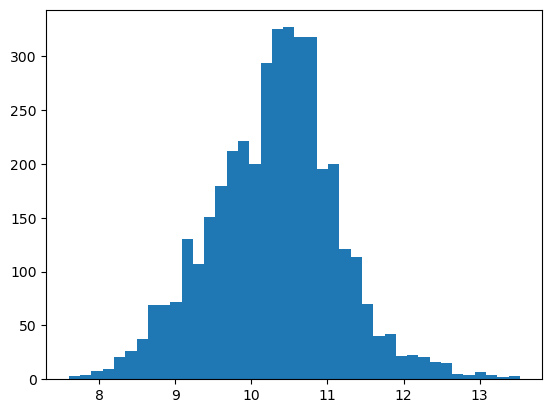

In [76]:
y_original_cleaned = y_original[y_original < 1000000]
y_original_ln_cleaned = np.log(y_original_cleaned)
plt.hist(y_original_cleaned, bins=40)
plt.show()
plt.hist(y_original_ln_cleaned, bins=40)
plt.show()

We will make 5 bins for the target variable, creating pseudo-classes in combination with the brand of the car for stratisfied sampling. This ensures that the test set is representative of the whole dataset.

In [61]:
# Make a new feature with the binning of the target column from ln
y_binned = pd.cut(y_original_ln, bins=5, labels=False)

# combine it with brand 
brand = data_original["brand"]
y_binned = y_binned.astype(str) + "_" + brand

# Look at if there are classes with few samples
print("Number of classes for sampling", len(y_binned.value_counts()))
print(len(y_binned.value_counts()[y_binned.value_counts() == 1]))
y_binned.value_counts()[y_binned.value_counts() == 1]

Number of classes for sampling 147
24


2_Buick          1
2_McLaren        1
3_Chevrolet      1
4_Porsche        1
0_Saturn         1
0_Porsche        1
2_Hummer         1
2_Maybach        1
0_Hummer         1
1_Saab           1
0_smart          1
4_Maserati       1
3_Cadillac       1
0_Mercury        1
1_Plymouth       1
1_Polestar       1
4_Lamborghini    1
3_Dodge          1
0_Maserati       1
4_Rolls-Royce    1
0_Saab           1
3_Ford           1
4_Bugatti        1
0_Suzuki         1
Name: count, dtype: int64

Since there are 24 pseudo-classes with only one sample (which would lead to problems in stratified sampling), we temporarly remove them and will distribute them randomly after the stratified sampling.

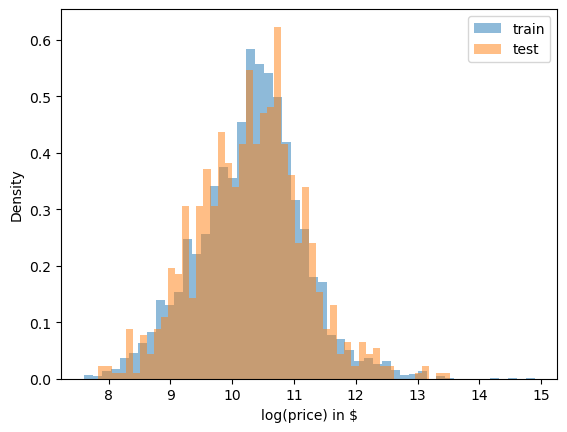

In [ ]:
from sklearn.model_selection import train_test_split

# All the classes with only one sample should be in a separate set which will be splitted in the end usind random sampling
X_single = data_original[y_binned.isin(y_binned.value_counts()[y_binned.value_counts() == 1].index)]

# Sampling usind stratified sampling for the classes with more than one sample
X = data_original.copy()[y_binned.isin(y_binned.value_counts()[y_binned.value_counts() > 1].index)]
y_stratified = y_binned[y_binned.isin(y_binned.value_counts()[y_binned.value_counts() > 1].index)]

# Stratified sampling usind y_binned 80% train and 20% test
X_train, X_test = train_test_split(X, test_size=0.2, stratify=y_stratified, random_state=42)

# Distribute the single samples among the train and test set
X_single_1, X_single_2 = train_test_split(X_single, test_size=0.2, random_state=42)
X_train = pd.concat([X_train, X_single_1])
X_test = pd.concat([X_test, X_single_2])

# Plot histograms of the target column for the train and test set, using percentage instead of counts
y_train = X_train["price"]
y_test = X_test["price"]

y_train_ln = np.log(y_train)
y_test_ln = np.log(y_test)


plt.hist(y_train_ln, bins=50, density=True, alpha=0.5, label="train")
plt.hist(y_test_ln, bins=50, density=True, alpha=0.5, label="test")
plt.xlabel("log(price) in $")
plt.ylabel("Density")
plt.legend()
plt.show()

The plot ($$$) shows that the distribution of the target variable between the train and test set is close to similar.

In [82]:
# Compare the brand distribution in the train and test set
brand_train = X_train["brand"]
brand_test = X_test["brand"]

df_brand = pd.DataFrame({"train": brand_train.value_counts(normalize=True), "test": brand_test.value_counts(normalize=True)})
# Multiply by 100 to get percentage
df_brand = df_brand * 100

df_brand["diff"] = df_brand["train"] - df_brand["test"]
df_brand

,train,test,diff
brand,,,
Acura,1.590271,1.620948,-0.030676
Alfa,0.498909,0.374065,0.124844
Aston,0.218273,0.249377,-0.031104
Audi,4.989086,4.987531,0.001555
BMW,9.354537,9.351621,0.002916
Bentley,0.810727,0.872818,-0.062091
Bugatti,0.031182,NaN,NaN
Buick,0.748363,0.748130,0.000233
Cadillac,2.619270,2.867830,-0.248560


In [84]:
# Print length of train and test set
print("Length of train set:", len(X_train))
print("Length of test set:", len(X_test))

Length of train set: 3207
Length of test set: 802


The distribution of the brands should be sufficiently similar between the train and test set.

In [85]:
X_train.head()

# Save the train and test set
X_train.to_csv("data/Original/train.csv", index=False)
X_test.to_csv("data/Original/test.csv", index=False)